In [1]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [34]:
#####################################################################
## Parameters
#####################################################################
parser = argparse.ArgumentParser()
parser.add_argument('-n', '--niter', default=100, type=int)
parser.add_argument('-b', '--batchSize', default=128, type=int)
parser.add_argument('--lr', default=0.5, type=float)
parser.add_argument('--gpu', default=0, type=int)
parser.add_argument('--log', default=50, type=int)
parser.add_argument('--nUseJoint', default=31, type=int)
parser.add_argument('--dimEmbedding', default=8, type=int)
parser.add_argument('--cuda', default=True, type=bool)


_StoreAction(option_strings=['--cuda'], dest='cuda', nargs=None, const=None, default=True, type=<class 'bool'>, choices=None, help=None, metavar=None)

<class 'list'>
Namespace(batchSize=128, cuda=True, dimEmbedding=4, gpu=0, log=50, lr=0.5, nUseJoint=31, niter=100)
Namespace(batchSize=128, cuda=True, dimEmbedding=8, gpu=0, log=50, lr=0.5, nUseJoint=31, niter=100)
Namespace(batchSize=128, cuda=True, dimEmbedding=16, gpu=0, log=50, lr=0.5, nUseJoint=31, niter=100)
Namespace(batchSize=128, cuda=True, dimEmbedding=64, gpu=0, log=50, lr=0.5, nUseJoint=31, niter=100)


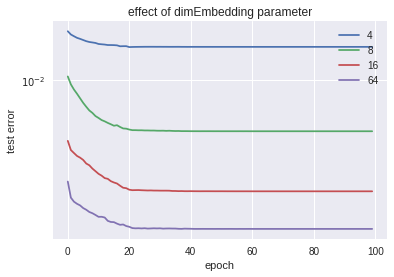

In [73]:
jk = JKPlot(['../result/'], parser)

testError = {}
legendDim = []
# plt.hold('on')

for dim in [4, 8, 16, 64]:
    res, args = jk.load_result(dimEmbedding=dim)
    testError[dim] = res[1][-1]
    plt.plot(res[1], label=dim)
    
# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# print(labels, handles)
# ax.legend(handles, labels)

plt.legend()
plt.title('effect of dimEmbedding parameter')
plt.xlabel('epoch')
plt.ylabel('test error')
plt.yscale('log')
# plt.savefig('../assets/plot_embedding.png')

In [61]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import re
import argparse
import random

def set_matplotlib():
    # Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
#     rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})

#     # Set the font used for MathJax - more on this later
#     rc('mathtext',**{'default':'regular'})

    params = {
       'axes.labelsize': 8,
       'font.size': 8,
       'legend.fontsize': 10,
       'xtick.labelsize': 10,
       'ytick.labelsize': 10,
       'text.usetex': False,
       'figure.figsize': [6., 4.] # instead of 4.5, 4.5
       }
    plt.rcParams.update(params)


class JKPlot(object):
    """
    Plot utility class for general purpose based on argparse
    """
    def __init__(self, dResult, parser, ext='npy', fList=None):
        """
        dResult : list of directories containing result files
        parser  : argparse object
        ext     : extension to extract
        """
        print(type(dResult))
        assert(type(dResult) == list)
        self.dResult = dResult
        self.parser = parser
        
        if fList == None:
            self.fList = []
            for res in dResult:
                self.fList += [res+f for f in os.listdir(res) if f.endswith(ext)]

        else:
            self.fList = fList
        
    def load_file(self, f):
        """
        load file f, depending on the saved format
        """
        res = np.load(f)
        # ...
        
        return res
    
    def remove_file(self, **kwargs):
        for f in self.fList:
            fName = os.path.basename(f)
            params = fName.split('_')
            
            args, temp = self.parser.parse_known_args(params)
            dic = vars(args)
            
            bFind = True
            for key in kwargs:
                if dic[key] != kwargs[key]:
                    bFind = False
                    break
                
            if bFind == True:
                os.remove(f)
                return
            
    def load_result(self, **kwargs):
        """
        load one result for given parameter
        Usage:
        >>> res = load_result(opt='sgd', lr=0.05, batchSize=32, dropout=0)
        """
        random.shuffle(self.fList)
        for f in self.fList:
            fName = os.path.basename(f)
            params = fName.split('_')
            args, temp = self.parser.parse_known_args(params)
            dic = vars(args)

            bFind = True
            for key in kwargs:
                if dic[key] != kwargs[key]:
                    bFind = False
                    break

            if bFind == True:
                print(args)
                res = np.load(f)
                return res, args
          
    def generate(self, **kwargs):
        """
        generate results of having parameters represented in kwargs
        """
        for f in self.fList:
            fName = os.path.basename(f)
            params = fName.split('_')
            
            args, temp = self.parser.parse_known_args(params)
            dic = vars(args)
            
            bFind = True
            for key in kwargs:
                if dic[key] != kwargs[key]:
                    bFind = False
                    break
                
            if bFind == True:
                res = self.load_file(f)        
                yield res, args
                
    def varying_params(self, varying, **fixed):
        """
        generate results while varying given parameters of kwargs
        
        Args
        - fixed (dictionary) : fixed parameters
        - varying (list) : varying parameters
        """
        bFind = False
        while (bFind == False):
            
            # randomly choose one
            r = random.randint(0, len(self.fList)-1)
            f = self.fList[r]
            
            fName = os.path.basename(f)
            params = fName.split('_')

            args, temp = self.parser.parse_known_args(params)
            dic = vars(args)

            for key in dic:
                if key in fixed and fixed[key] != dic[key]:
                    bFind = False
                    break
                    
                fixed[key] = dic[key]
            
            bFind = True
            
        print(fixed)
        
        # generate
        for f in self.fList:
            fName = os.path.basename(f)
            params = fName.split('_')
            
            # fixed params
            args, temp = self.parser.parse_known_args(params)
            dic = vars(args)
            
            bFind = True
            for key in dic:
                # in the case of varying param
                if key in varying:
                    continue
                
                # if the fixed param is different, 
                if key in fixed and dic[key] != fixed[key]:
                    bFind = False
                    break
                    
                    
            # if the fixed params are the same,
            if bFind == True:
                res = self.load_file(f)
                yield res, args

In [60]:
lst = [1970, 1991, 2012]
random.shuffle(lst)
for x in lst:
    print(x)

2012
1991
1970
